In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [63]:
# Consts etc.
data_path = "data/"

# Experiment 1

In [64]:
# Load data

e1_file_names = ["experiment 1 run 1.txt", "experiment 1 run 2.txt", "experiment 1 run 3.txt"]
e1_data = []
e1_init_cutoffs = [770, 3, 1]  # From 'data_sanity_check.ipynb'

for i, file_name in enumerate(e1_file_names):
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e1_column_names = db_temp.iloc[0]
    e1_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e1_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    db_temp = db_temp.iloc[e1_init_cutoffs[i]:]
    e1_data.append(db_temp)

# Make sure the data has uniform number of points
min_mes_count = min([len(e1_data[i]["Tijd"]) for i in range(len(e1_data))])
for i in range(len(e1_data)):
    e1_data[i] = e1_data[i].iloc[:min_mes_count]

# Test
print(e1_data[0].head())
print(len(e1_data[0]["Tijd"]))
print(len(e1_data[1]["Tijd"]))
print(len(e1_data[2]["Tijd"]))

0       Tijd     Ch1     Ch2
772  769.096  1029.0  1016.0
773  770.096   988.0   963.0
774  771.097   953.0   930.0
775  772.096   922.0   900.0
776  773.096   893.0   871.0
284
284
284


In [65]:
# Calculate the mean and average in the mean of the three runs
def mean_and_std(data):
    return np.mean(data), np.std(data)

def mean_and_std_of_runs(data_list):
    mean_data = []
    std_data = []
    for i in range(len(data_list[0])):
        data = [data_list[j][i] for j in range(len(data_list))]
        mean, std = mean_and_std(data)
        mean_data.append(mean)
        std_data.append(std)
    return np.array(mean_data), np.array(std_data)

In [66]:
mean_data, std_data = mean_and_std_of_runs([df["Ch1"].values for df in e1_data])

# New pandas dataframe to store the processed data
results_df = pd.DataFrame({
    "Tijd": e1_data[0]["Tijd"].values,
    "Mean_Ch1": mean_data,
    "Std_Ch1": std_data
})

# Test
print(results_df.head())

      Tijd     Mean_Ch1    Std_Ch1
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361


[]

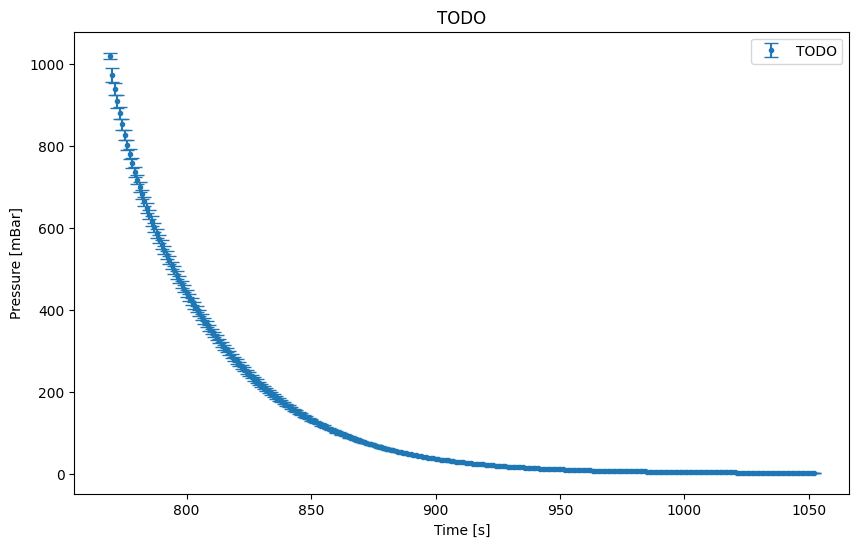

In [67]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Tijd"], results_df["Mean_Ch1"], yerr=results_df["Std_Ch1"], fmt='.', label='TODO', capsize=5)

plt.title("TODO")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [mBar]")

plt.legend()
plt.plot()